In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

## Update this to have the path to extreme-deconvolution's python library

In [3]:
import lib.toy_data as toy_data
import lib.utils as utils
from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from train_misc import build_model_tabular

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

from matplotlib import pyplot as plt
import pickle as pkl

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
foo = pd.read_pickle('/Users/landerson/projects/cmd_flows/fullpop.pkl')

In [32]:
len(foo)

1689357

In [6]:
nsamplesdata = 1000000
ssfilename = f'transform_nsamples{nsamplesdata}.pkl'
datafilename = f'fullpop_nsamples{nsamplesdata}.pkl'
try:
    data_np = pd.read_pickle(datafilename)
    ss = pkl.load(open(ssfilename,'rb'))
    
except FileNotFoundError:
    data_np = pd.read_pickle('/Users/landerson/projects/cmd_flows/fullpop.pkl').sample(nsamplesdata)
    data_np.to_pickle(datafilename)
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(np.array(data_np))
    import pickle
    pickle.dump(ss, open(f'transform_nsamples{nsamplesdata}.pkl','wb'))
N = len(data_np)
data = torch.from_numpy(np.array(data_np).astype(np.float32))

raw_np = np.load('quick_isochrone.npy')
raw_np = raw_np

raw = pd.DataFrame({'G': raw_np[:, 0], 'bp_rp': raw_np[:, 1]})

#Add some noise:

raw['g_std'] = np.random.rand(len(raw))*0.3 + 1e-3
raw['bp_rp_p'] = raw['bp_rp'] + raw['g_std']*np.random.randn(len(raw))
raw['G_p'] = raw['G'] + raw['g_std']*np.random.randn(len(raw))


use_cols = ['G_p', 'bp_rp_p', 'g_std']#, 'BP', 'RP']
cond_cols = []

npdata = np.array(raw[use_cols + cond_cols])
ss.fit(npdata)
data = torch.from_numpy(npdata.astype(np.float32))

raw[use_cols + cond_cols].describe()

In [7]:
data_np.values.shape

(1000000, 5)

In [ ]:
H, edges = np.histogramdd(data_np.values, bins=100)

AttributeError: 'list' object has no attribute 'shape'

In [7]:
traindataset = TensorDataset(data[:-(N//5)])
testdataset = TensorDataset(data[-(N//5):])
batch = 1024
train = DataLoader(traindataset, batch_size=batch, shuffle=True, drop_last=True)
test = DataLoader(testdataset, batch_size=batch, shuffle=False)

In [8]:
args = pkl.load(open('args.pkl', 'rb'))

In [40]:
args.niters

10000

In [34]:
args

Namespace(JFrobint=None, JdiagFrobint=None, JoffdiagFrobint=None, atol=1e-05, batch_norm=False, batch_size=100, bn_lag=0, data='8gaussians', dims='64-64-64', divergence_fn='brute_force', dl2int=None, gpu=0, l1int=None, l2int=None, layer_type='concatsquash', log_freq=10, lr=0.001, niters=10000, nonlinearity='tanh', num_blocks=1, rademacher=False, residual=False, rtol=1e-05, save='experiment1', solver='dopri5', spectral_norm=False, step_size=None, test_atol=None, test_batch_size=1000, test_rtol=None, test_solver=None, time_length=0.5, train_T=True, val_freq=100, viz_freq=100, weight_decay=1e-05)

In [9]:
data.shape

torch.Size([1000000, 5])

In [10]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, 5, regularization_fns).to(device)#.cuda()

In [11]:
if args.spectral_norm: add_spectral_norm(model)
set_cnf_options(args, model)

In [12]:
from torch import optim

In [13]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [14]:
transform_scale = torch.from_numpy(ss.scale_).float().to(device)[np.newaxis, :]
transform_mean = torch.from_numpy(ss.mean_).float().to(device)[np.newaxis, :]

def compute_loss(args, model, X, batch_size=None):
    if batch_size is None: batch_size = args.batch_size
    X = X.to(device)

    x = (X-transform_mean)/transform_scale
#     return X
    # load data
#     x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
#     x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

In [15]:
from lib import utils

In [16]:
import time

In [17]:
time_meter = utils.RunningAverageMeter(0.93)
loss_meter = utils.RunningAverageMeter(0.93)
nfef_meter = utils.RunningAverageMeter(0.93)
nfeb_meter = utils.RunningAverageMeter(0.93)
tt_meter = utils.RunningAverageMeter(0.93)

In [23]:
model.load_state_dict(
    torch.load('model_46000.pt')
);

In [18]:
itr = 0

In [19]:
model = model.to(device) #cuda()
model.train();

# You can skip this:

In [ ]:
end = time.time()
itr = 0
while itr < 10:

    for (X,) in train:
        optimizer.zero_grad()

        if args.spectral_norm: spectral_norm_power_iteration(model, 1)

        loss = compute_loss(args, model, X)
        #print(loss)
        loss_meter.update(loss.item())
        total_time = count_total_time(model)
        nfe_forward = count_nfe(model)
        loss.backward()
        optimizer.step()

        itr += 1

        if itr % 50 == 0:
            nfe_total = count_nfe(model)
            nfe_backward = nfe_total - nfe_forward
            nfef_meter.update(nfe_forward)
            nfeb_meter.update(nfe_backward)

            time_meter.update(time.time() - end)
            tt_meter.update(total_time)

            log_message = (
                'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f}) | NFE Forward {:.0f}({:.1f})'
                ' | NFE Backward {:.0f}({:.1f}) | CNF Time {:.4f}({:.4f})'.format(
                    itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, nfef_meter.val, nfef_meter.avg,
                    nfeb_meter.val, nfeb_meter.avg, tt_meter.val, tt_meter.avg
                )
            )
            print(log_message)

/Users/landerson/projects/extinctions/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


Iter 0050 | Time 28.1992(28.1992) | Loss 6.241961(6.428853) | NFE Forward 20(20.0) | NFE Backward 20(20.0) | CNF Time 0.5000(0.5000)
Iter 0100 | Time 81.5743(31.9355) | Loss 3.879878(4.255425) | NFE Forward 38(21.3) | NFE Backward 32(20.8) | CNF Time 0.5000(0.5000)


In [ ]:
from lib.visualize_flow import visualize_transform

In [ ]:
p_samples.values

In [ ]:
standard_normal_logprob

In [ ]:
import os

In [25]:
import corner

In [21]:
data_np.columns

Index(['G-J', 'J-H', 'H-K', 'K-W1', 'G_mag'], dtype='object')

In [20]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

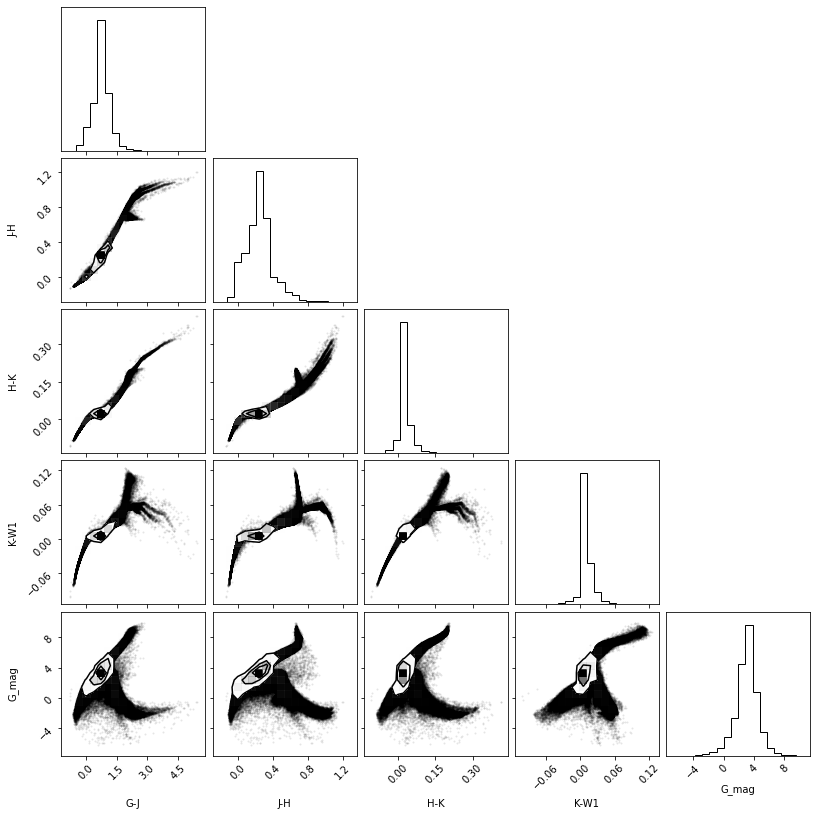

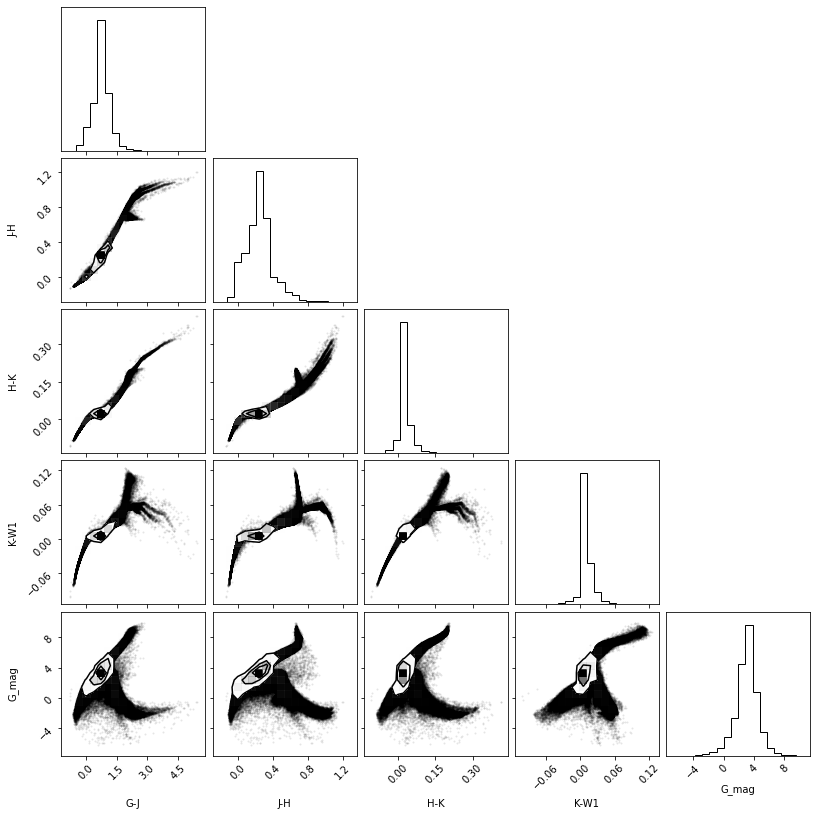

In [26]:
labels = data_np.columns
bins = [np.linspace(np.min(data_np[c]), np.max(data_np[c]), 100) for c in data_np.columns]
means = [data_np[c].mean() for c in data_np.columns]
stds = [data_np[c].std() for c in data_np.columns]
binrange = [[np.min(b)-s, np.max(b)+s] for b, s in zip(bins, stds)]#[[np.min(b)-s, np.max(b)+s] for b, s in zip(bins, stds)]
corner.corner(data_np, label=labels, range=binrange)

In [29]:
sample_fn, density_fn = get_transforms(model)

In [30]:
npts=500
memory = 100
z = torch.randn(npts * npts, 5).type(torch.float32).to(device)
zk = []
inds = torch.arange(0, z.shape[0]).to(torch.int64)
for ii in torch.split(inds, int(memory**2)):
    zk.append(sample_fn(z[ii]))
zk = torch.cat(zk, 0).detach().numpy()

/Users/landerson/projects/extinctions/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [86]:
ss = pkl.load(open('transform_nsamples225617.pkl','rb'))

/opt/anaconda3/envs/nflows/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [43]:
pkl.dump(ss.inverse_transform(zk), open(f'nfsamples_nsamples{nsamplesdata}.pkl','wb'))

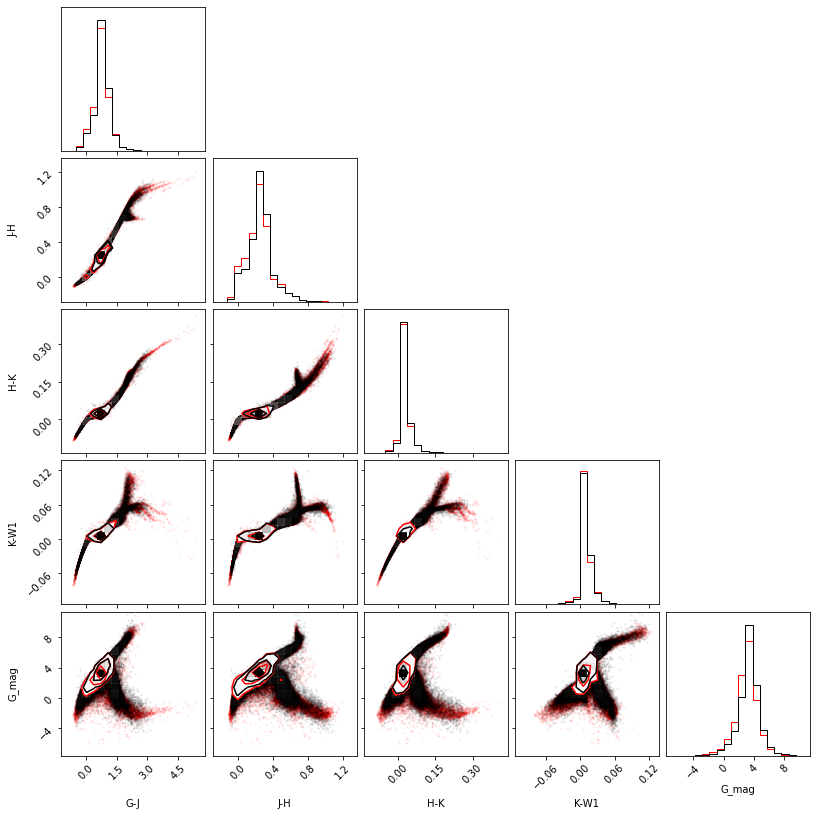

In [38]:
fig = corner.corner(data_np.sample(500*500), label=labels, range=binrange, color='red')
corner.corner(ss.inverse_transform(zk), label=labels, fig=fig, range=binrange)
fig.savefig('normflow.pdf')

In [29]:
data_np.median()

G-J      0.768934
J-H      0.244440
H-K      0.021718
K-W1     0.007941
G_mag    3.074058
dtype: float64

In [46]:
x[:,0,0,0,:].shape

(100, 100)

In [99]:
npts = 100
xside = np.linspace(-3, 3, npts)
yside = np.linspace(-3, 3, npts)
xx, yy = np.meshgrid(xside, yside)
x = np.zeros([npts*npts, 5])
x[:,0] = xx.reshape(-1)
x[:, 4] = yy.reshape(-1)
#x[0:2,:] = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
#x[:, 1] += data_np['J-H'].median()
#x[:, 2] += data_np['H-K'].median()
#x[:, 3] += data_np['K-W1'].median()
#x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
#x = (x-ss.mean_)/ss.scale_

In [100]:
print(x.shape)
x = torch.from_numpy(x).type(torch.float32).to(device)
x.requires_grad = True
zeros = torch.zeros(x.shape[0], 1).to(x)

z, delta_logp = [], []
inds = torch.arange(0, x.shape[0]).to(torch.int64)
for ii in torch.split(inds, int(memory**2)):
    print(x[ii].shape, zeros[ii].shape)
    z_, delta_logp_ = density_fn(x[ii], zeros[ii])
    z.append(z_)
    delta_logp.append(delta_logp_)
z = torch.cat(z, 0)
delta_logp = torch.cat(delta_logp, 0)

logpz = standard_normal_logprob(z).view(z.shape[0], -1).sum(1, keepdim=True)  # logp(z)
logpx = logpz - delta_logp
px = np.exp(logpx.detach().numpy()).reshape(npts, npts)


(10000, 5)
torch.Size([10000, 5]) torch.Size([10000, 1])


In [101]:
logpx.sum().backward()
grad = x.grad.reshape((npts, npts, 5))


In [106]:
args

Namespace(JFrobint=None, JdiagFrobint=None, JoffdiagFrobint=None, atol=1e-05, batch_norm=False, batch_size=100, bn_lag=0, data='8gaussians', dims='64-64-64', divergence_fn='brute_force', dl2int=None, gpu=0, l1int=None, l2int=None, layer_type='concatsquash', log_freq=10, lr=0.001, niters=10000, nonlinearity='tanh', num_blocks=1, rademacher=False, residual=False, rtol=1e-05, save='experiment1', solver='dopri5', spectral_norm=False, step_size=None, test_atol=None, test_batch_size=1000, test_rtol=None, test_solver=None, time_length=0.5, train_T=True, val_freq=100, viz_freq=100, weight_decay=1e-05)

/opt/anaconda3/envs/nflows/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


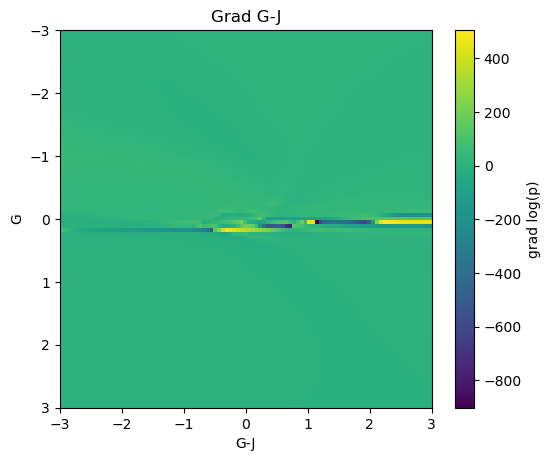

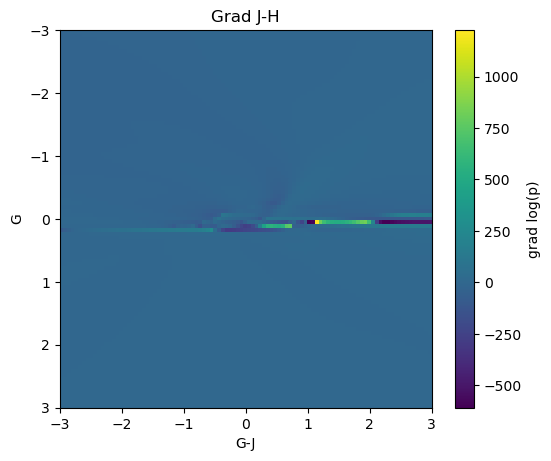

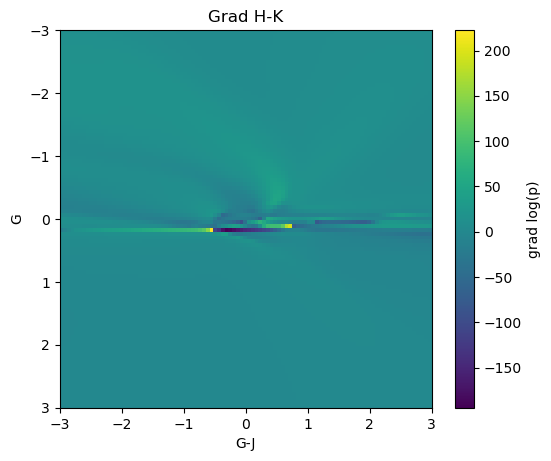

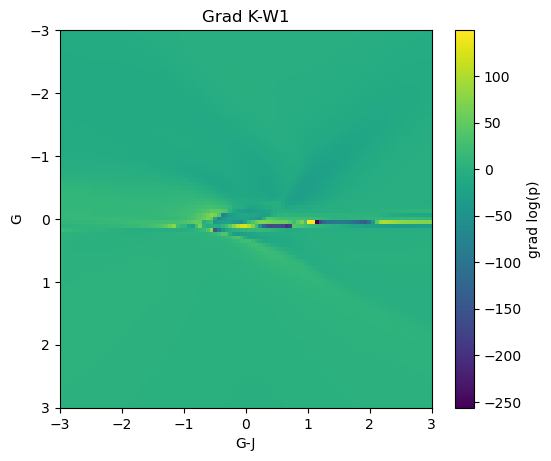

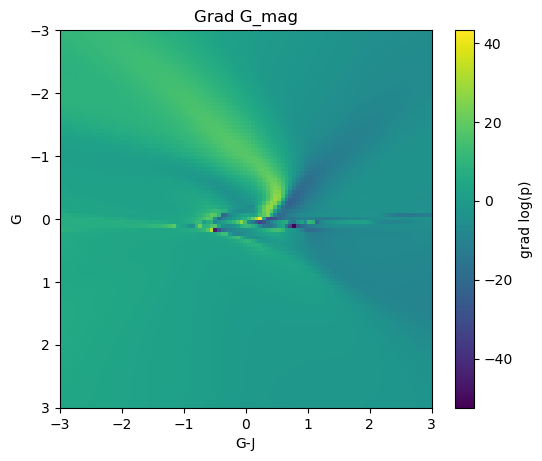

In [107]:
for i in range(5):
    plt.figure(figsize=(6, 5), dpi=100)
    xe = np.linspace(-3, 3, 100)
    plt.pcolormesh(xe, xe, grad[:, :, i].numpy().T)#[::-1]) #, extent=[-3, 3, -3, 3], aspect='auto') #, vmin=-100, vmax=100)
    #titles = ['BP-RP', 'G']
    # Is this order right?
    plt.title(f'Grad {labels[i]}')
    plt.gca().invert_yaxis()
    plt.colorbar(label='grad log(p)')
    plt.xlabel('G-J')
    plt.ylabel('G')
    plt.show()

In [ ]:
grid_size = 500
a
xline = torch.linspace(-0.5, 1.0, grid_size)
yline = torch.linspace(-2, 5, grid_size)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([ygrid.reshape(-1, 1), xgrid.reshape(-1, 1)], dim=1)
xyinput.requires_grad = True

log_prob = -model.log_prob(xyinput / 15 + 0.5).sum()
log_prob.backward()

grad = xyinput.grad.reshape((grid_size, grid_size, 2))


change worked


/Users/landerson/projects/extinctions/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


NameError: name 'corner' is not defined

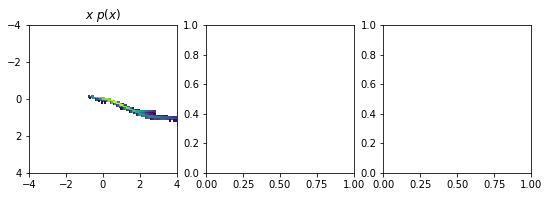

In [24]:


from lib.visualize_flow import visualize_transform
model.eval()
p_samples = pd.read_pickle('/Users/landerson/projects/cmd_flows/fullpop.pkl').sample(1000000)

sample_fn, density_fn = get_transforms(model)

plt.figure(figsize=(9, 3))
visualize_transform(
    p_samples.values, torch.randn, standard_normal_logprob, transform=sample_fn, inverse_transform=density_fn,
    samples=True, npts=100, device=device
)
itr = 0
#args.save = '.'
#fig_filename = os.path.join(args.save, 'figs', '{:04d}.jpg'.format(itr))
#utils.makedirs(os.path.dirname(fig_filename))
#plt.savefig(fig_filename)
#plt.close()
#model.train()

In [29]:
# torch.save(model.cpu().state_dict(), open('demo_model_ode_flow_v9.pt', 'wb'))

# model.cpu();

In [27]:
from matplotlib import pyplot as plt

In [28]:
ss.mean_, ss.scale_

(array([3.4491446 , 0.10471355, 0.15059592]),
 array([1.30973375, 0.29721055, 0.086588  ]))

In [29]:
model = model.cpu()
#model.eval();

In [30]:
from torch.functional import F

In [32]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    
    return logpx

def soft_lo_clamp(x, lo):
    return F.softplus(x-lo) + lo

# for age in np.linspace(9.1, 9.9, num=10):
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5*2, 5*2))
# ax = ax.ravel()
model#.cuda()
minG = -2#np.percentile(raw['G'], 3)
maxG = 5#np.percentile(raw['G'], 100-3)
minbprp = -0.5#np.percentile(raw['bp_rp'], 3)
maxbprp = 1#np.percentile(raw['bp_rp'], 100-3)
num = 100
pG, pbprp = np.meshgrid(np.linspace(minG, maxG, num=num), np.linspace(minbprp, maxbprp, num=num))
pG = pG.reshape(-1)
pbprp = pbprp.reshape(-1)

pdatap = np.zeros((len(pG), len(use_cols) + len(cond_cols)), dtype=np.float32)
pdatap[:, 0] = pG
pdatap[:, 1] = pbprp

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()
logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()
#logprob_xd = soft_lo_clamp(
#    torch.from_numpy(np.log(np.exp(xd.logprob_a(pdatap[:, [1, 0]], 0.0*np.eye(2)[np.newaxis]*np.ones(len(pdatap[:]))[:, None, None])).sum(1))), -100).numpy()

_exp = lambda _x: np.exp(_x/4)
#prob_xd = _exp(logprob_xd.reshape(num, num))
prob = _exp(logprob.reshape(num, num))

/Users/landerson/AstroHackWeek2020/hacks/smoothflows/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [33]:
import matplotlib as mpl

In [34]:
import torch

In [35]:
torch.autograd.grad?

Signature:
torch.autograd.grad(
    outputs: Union[torch.Tensor, Sequence[torch.Tensor]],
    inputs: Union[torch.Tensor, Sequence[torch.Tensor]],
    grad_outputs: Union[torch.Tensor, Sequence[torch.Tensor], NoneType] = None,
    retain_graph: Union[bool, NoneType] = None,
    create_graph: bool = False,
    only_inputs: bool = True,
    allow_unused: bool = False,
) -> Tuple[torch.Tensor, ...]
Docstring:
Computes and returns the sum of gradients of outputs w.r.t. the inputs.

``grad_outputs`` should be a sequence of length matching ``output``
containing the "vector" in Jacobian-vector product, usually the pre-computed
gradients w.r.t. each of the outputs. If an output doesn't require_grad,
then the gradient can be ``None``).

If ``only_inputs`` is ``True``, the function will only return a list of gradients
w.r.t the specified inputs. If it's ``False``, then gradient w.r.t. all remaining
leaves will still be computed, and will be accumulated into their ``.grad``
attribute.

Arguments:

In [36]:
model.parameters()

<generator object Module.parameters at 0x1a2ba0bdd0>

In [21]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)
    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)
    logpx = logpz - delta_logp
    return logpx

In [22]:
class Objective(nn.Module):
    def __init__(self, model, x):
        super(Objective, self).__init__()
        self.x = nn.Parameter(x, requires_grad=True)
        #self.model = model.requires_grad_(True)
        
    def forward(self, foo=None):
        return -1.*self.lnprob()
    
    def lnprob(self):
        #self.model.eval()
        zeros = torch.zeros(self.x.shape[0], 1)
        z, delta_logp = model(self.x, zeros)
        logpz = standard_normal_logprob(z).sum(1, keepdim=True)
        logpx = logpz - delta_logp
        #pdata = torch.Tensor([self.x], device=device).unsqueeze(1)#.t()
        return logpx

In [39]:
x = torch.Tensor(np.array([1,1]), device=device).unsqueeze(1).t()
zeros = torch.zeros(2, 1)

In [40]:
minG = -2#np.percentile(raw['G'], 3)
maxG = 5#np.percentile(raw['G'], 100-3)
minbprp = -0.5#np.percentile(raw['bp_rp'], 3)
maxbprp = 1#np.percentile(raw['bp_rp'], 100-3)
num = 40
xM = np.linspace(minG, maxG, num=num)
xc = np.linspace(minbprp, maxbprp, num=num)
pG, pbprp = np.meshgrid(xM, xc)
pG = pG.reshape(-1)
pbprp = pbprp.reshape(-1)

pdatap = np.zeros((len(pG), len(use_cols) + len(cond_cols)), dtype=np.float32)
pdatap[:, 0] = pG
pdatap[:, 1] = pbprp

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()
 
logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()
_exp = lambda _x: np.exp(_x/4)
#prob_xd = _exp(logprob_xd.reshape(num, num))
prob = _exp(logprob.reshape(num, num))

/Users/landerson/AstroHackWeek2020/hacks/smoothflows/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


In [41]:
grads = np.zeros((pdata.shape[0], pdata.shape[1]-1))
for i, q in enumerate(pdata):
    #print(q.shape)
    obj = Objective(model, q[:2].unsqueeze(1).t())
    o = obj()
    o.backward()
    for name, p in obj.named_parameters():
        if name == 'x': grads[i,:] = p.grad.data.numpy()


/opt/anaconda3/envs/nflows/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/nflows/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


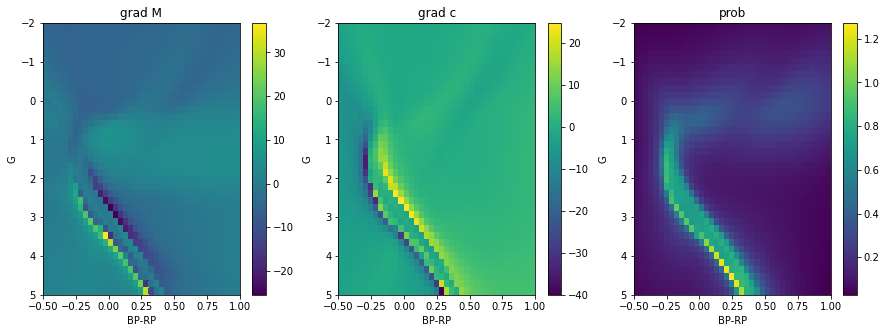

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
titles = ['grad M', 'grad c', 'prob']
for i, a in enumerate(ax[0:2]):
    im = a.pcolormesh(xc, xM, grads.reshape(num, num, 2)[:,:,i].T)
    plt.colorbar(im, ax=a)
im = ax[2].pcolormesh(xc, xM, prob.T)#, cmap='jet')
plt.colorbar(im, ax=ax[2])
for a, t in zip(ax, titles):
    a.invert_yaxis()
    a.set_xlabel('BP-RP')
    a.set_ylabel('G')
    a.set_title(t)

In [43]:
from hessian import hessian

In [234]:
hessian(o, obj.parameters())

AssertionError: 

In [237]:
torch.autograd.functional.hessian(obj, torch.zeros(1))

tensor([[0.]])

In [53]:
torch.Tensor([0.1, 0.1]).unsqueeze(1).t().shape

torch.Size([1, 2])

In [61]:
def cache(self, x):
    # unpack x and load into module 
    state_dict = self.unpack_parameters(x)
    self.f.load_state_dict(state_dict)
    # store the raw array as well
    self.cached_x = x
    # zero the gradient
    self.f.zero_grad()
    # use it to calculate the objective
    obj = self.f()
    # backprop the objective
    obj.backward()
    self.cached_f = obj.item()
    self.cached_jac = self.pack_grads()
    self.cached_hes = hessian(self.f(), self.f.parameters())

obj.zero_grad()
o = obj()
o.backward()
grads = []
for p in obj.parameters():
    print(p, p.grad)
    #import pdb; pdb.set_trace()
    grad = p.grad.data.numpy()
    grads.append(grad.ravel())
grads = np.concatenate(grads)

/Users/landerson/AstroHackWeek2020/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


RuntimeError: grad can be implicitly created only for scalar outputs

In [36]:
from matplotlib.colors import Normalize

class CustomNorm(Normalize):
    def __init__(self, alpha, clip=False):
        # input levels
        self.alpha = alpha
        # corresponding normalized values between 0 and 1
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return (value/value.max())**self.alpha#(np.log10((value)+1e-10)+10)/10/1.013 

    def inverse(self, value):
        return 1.0 - self.__call__(value)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


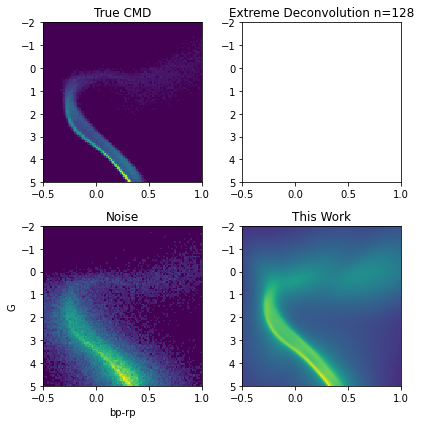

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
ax = ax.ravel()
norm = CustomNorm(0.5)
# ax[0].scatter(*np.array(raw[['bp_rp', 'G']]).T, s=0.1, alpha=0.1)
h, _, _, _ = ax[0].hist2d(raw['bp_rp'], raw['G'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[0].set_title('True CMD')
ax[2].hist2d(raw['bp_rp_p'], raw['G_p'], bins=100, range=[(minbprp, maxbprp), (minG, maxG)], norm=norm, normed=True)
ax[2].set_title('Noise')
# plotXdgmm(xd, ax[1])


cax = ax[1]
#cax.imshow(prob_xd.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('Extreme Deconvolution n=128')
cax = ax[3]
cax.imshow(prob.T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
cax.set_title('This Work')
# cax = ax[5]
# cax.imshow(np.abs(prob-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')
# cax = ax[2]
# cax.imshow(np.abs(prob_xd-h).T, origin='lower', extent=[minbprp, maxbprp, minG, maxG], aspect='auto', norm=norm)#, cmap='jet')
# cax.set_title('Absolute Residual')

# cax.cbar()
ax[2].set_ylabel('G')
ax[2].set_xlabel('bp-rp')
for i in range(4):
    ax[i].set_ylim(5, -2)
    ax[i].set_xlim(minbprp, maxbprp)
# cax.set_title('feh_std=%f' % (feh_std,))

plt.tight_layout()
plt.savefig('t1.png', dpi=150)